# Coding Tutorial 5: Unsupervised Learning

In this coding tutorial, we learn how to do the following for `k-means` clustering and principal components analysis:

- Import models from `scikit-learn`
- Prepare a pandas dataframe for analysis with `scikit-learn`
- Instantiate and fit a model to data
- Visualise the results of the model

# Importing Models from Scikit-Learn

`scikit-learn` is actually a collection of modules, so you will need to find which sub-module contains the model you want to use.

In [4]:
# standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# scikit-learn imports
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [5]:
# read in data
df = pd.read_feather("../Week2/data/bes_data_subset_week2.feather")

# Data Pre-Processing

There are four steps for preparing data for analysis:

1. Feature Selection
2. Accounting for NAs
3. One Hot Encoding
4. Conversion to numpy ndarray

## Feature Selection

Here we just choose which columns we are going to use. If your data has a lot of NAs, it may be worthwhile to prefer columns with fewer NAs.

In [6]:
# df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2194 entries, 0 to 2193
Data columns (total 30 columns):
finalserialno           2194 non-null int32
region                  2194 non-null object
Constit_Code            2194 non-null object
Constit_Name            2194 non-null object
Interview_Date          2194 non-null object
total_num_dwel          2194 non-null object
total_num_hous          2194 non-null object
num_elig_people         2194 non-null object
turnoutValidationReg    1507 non-null category
Age                     2175 non-null float64
a01                     2194 non-null object
a02                     2132 non-null category
a03                     2194 non-null category
e01                     2194 non-null category
k01                     2194 non-null category
k02                     2194 non-null category
k03                     1103 non-null category
k11                     2194 non-null category
k13                     2194 non-null category
k06                 

In [11]:
# Copy-paste this:
df.columns.tolist()
# Delete as necessary
features = ['region', 'Age', 'a02', 'a03', 'e01',
            'k01', 'k02', 'k11', 'k13', 'k06', 'k08',
            'y01', 'y03', 'y06', 'y08', 'y09', 'y11', 'y17']

## Accounting for NAs

In [12]:
df[features].isna().sum()

region     0
Age       19
a02       62
a03        0
e01        0
k01        0
k02        0
k11        0
k13        0
k06        0
k08        0
y01        0
y03        0
y06        0
y08        0
y09        0
y11        0
y17        0
dtype: int64

In [14]:
df = df[features].dropna()

## One-Hot Encoding

We can do a one-hot encoding using the `pd.get_dummies()` function.

In [15]:
df.shape

(2114, 18)

In [16]:
data = pd.get_dummies(df)

In [19]:
data.shape

(2114, 143)

## Normalization and Conversion to `numpy`

We call the `StandardScaler().fit_transform()` function on the `.values` argument of the dataframe

In [20]:
X = data.values

In [21]:
# There's definitely a better way to do this
X_norm = data.apply(lambda x: x.apply(lambda r: (r-x.mean())/x.std())).values

# Instantiating and Fitting `k-means`

We first create an instance of the model, where we provide parameters, and then we pass data to it.

In [22]:
kmeans = KMeans(n_clusters=5, random_state=634)

In [23]:
kmeans.fit(X_norm)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=634, tol=0.0001, verbose=0)

We can extract the labels using the `.labels_` method, and then assign them to a column.

In [24]:
df['labels_'] = kmeans.labels_

# Visualising the Results

This is a bit difficult with so many variables. Let's look at age.

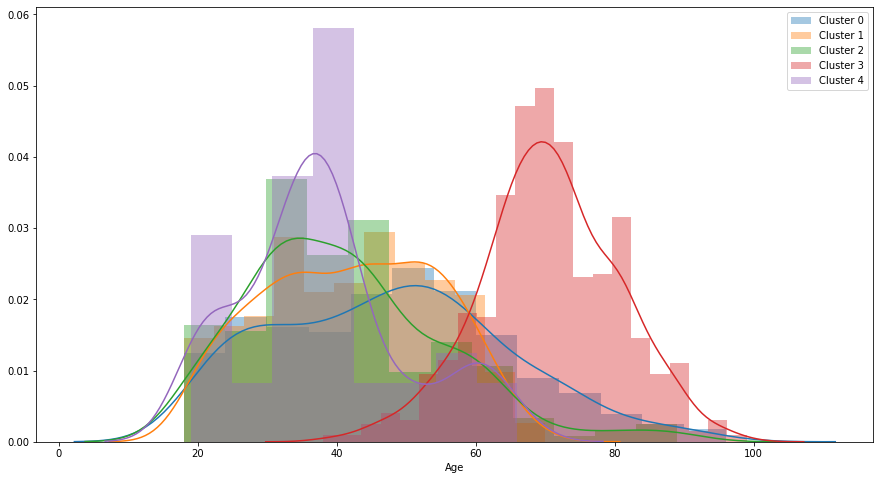

In [26]:
f, ax = plt.subplots(1, 1, figsize=(15, 8))
for label in range(5):
    sns.distplot(df.loc[df['labels_']==label, 'Age'],
                 ax=ax, label=f"Cluster {label}")
ax.legend()
None

In [28]:
# We can appropriate this function
def grouped_barplot(data, var1, var2):
    """
    Creates a grouped bar plot of the distribution of `var2` within each group of `var2`.
    """
    temp = data.groupby([var1, var2]).apply(len).reset_index().rename({0: 'Count'}, axis=1)
    f, ax = plt.subplots(1, 1, figsize=(len(data[var1].unique())*len(data[var1].unique())/5, 10))
    sns.barplot(data=temp, x=var1, y='Count', hue=var2)
    ax.set_title(f"BES Sample {var2} per {var1}")
    ax.xaxis.set_ticklabels(ax.xaxis.get_ticklabels(), rotation=30)

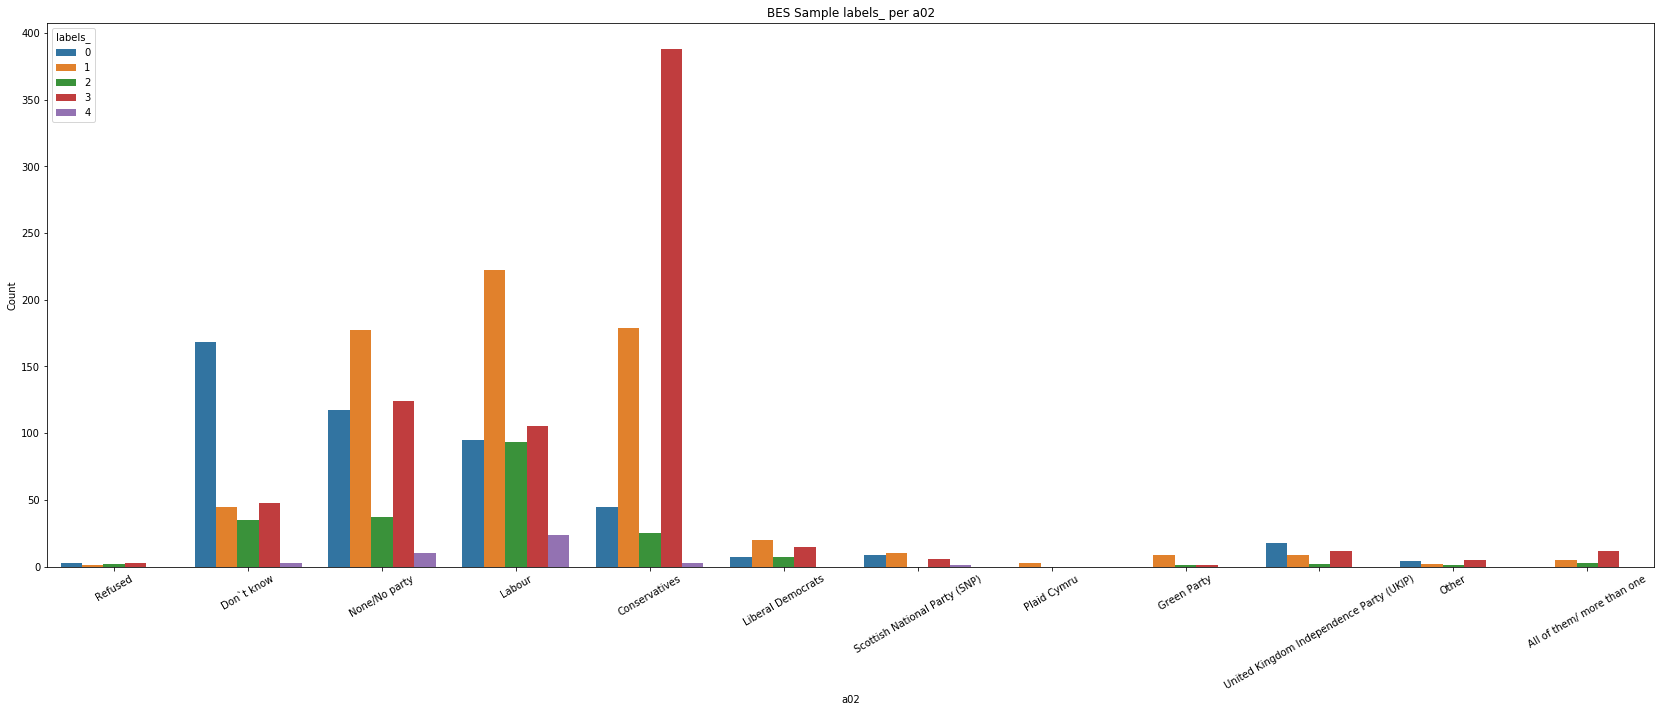

In [29]:
grouped_barplot(df, 'a02','labels_') 

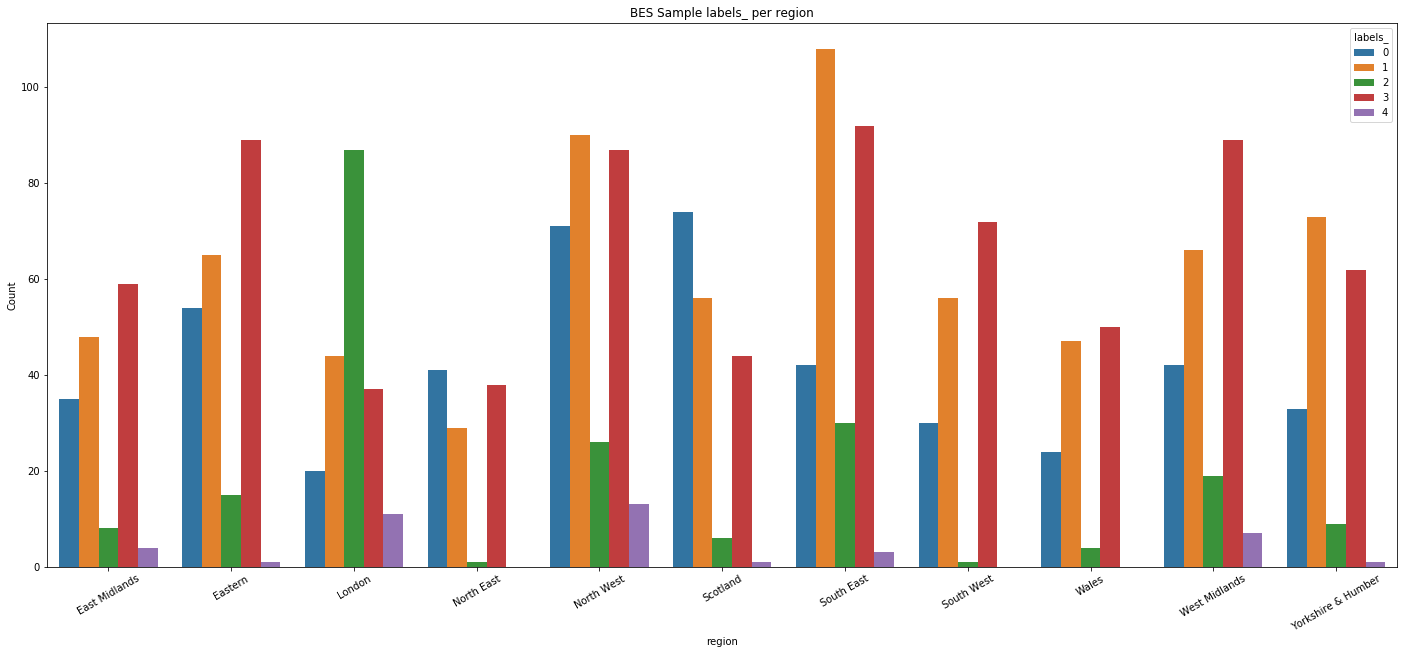

In [30]:
grouped_barplot(df, 'region','labels_')

## Instantiating and Fitting PCA

In [31]:
pca = PCA(n_components=2, random_state=634)
pca = pca.fit(X_norm)
reduced_X = pca.fit_transform(X_norm)

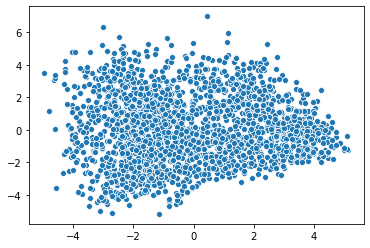

In [33]:
sns.scatterplot(x=reduced_X[:, 0], y=reduced_X[:, 1]) 
None

## Combining PCA and `k-means`

We can fit k-means to PCA-reduced data:

In [35]:
pcakmeans = KMeans(n_clusters=5, random_state=634)
pcakmeans.fit(reduced_X)
df['pcakmeans_labels'] = pcakmeans.labels_

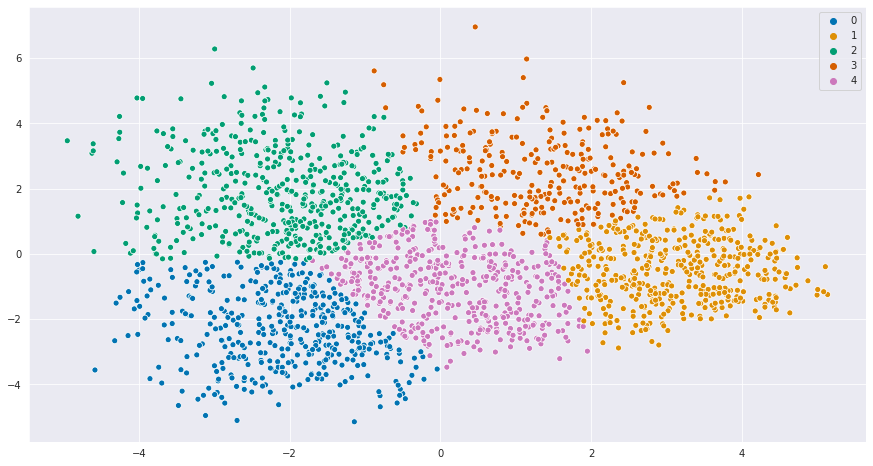

In [37]:
sns.set_style('darkgrid')
f, ax = plt.subplots(1, 1, figsize=(15, 8))
sns.scatterplot(x=reduced_X[:, 0], y=reduced_X[:, 1],
                hue=pcakmeans.labels_,
                palette=sns.color_palette(palette='colorblind', n_colors=5))
None

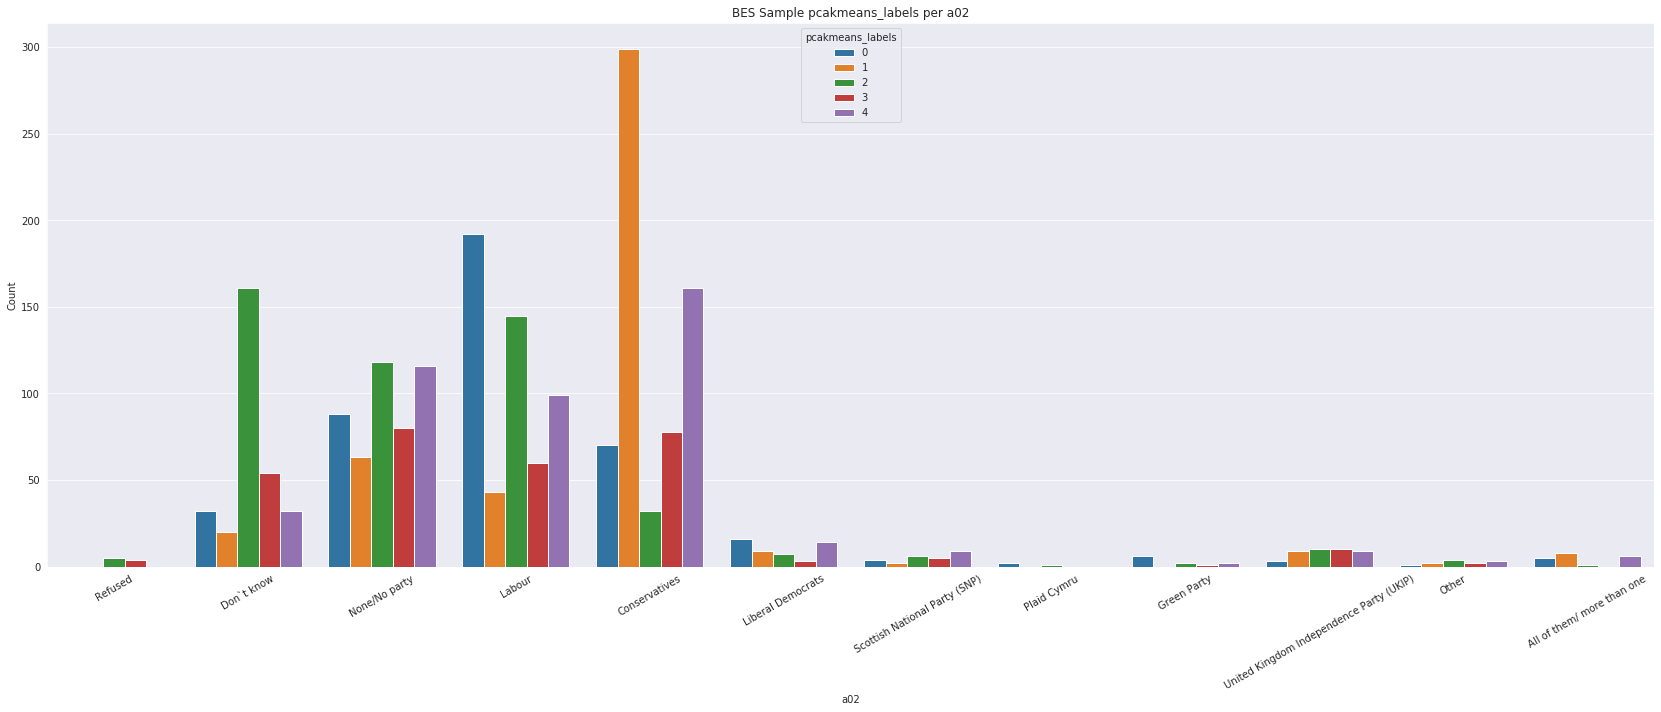

In [38]:
grouped_barplot(df, 'a02', 'pcakmeans_labels')

In [42]:
pd.DataFrame(pca.components_, columns=data.columns)

,Age,region_East Midlands,region_Eastern,region_London,region_North East,region_North West,region_Scotland,region_South East,region_South West,region_Wales,...,y17_Working full time - self-employed (30+ hours),y17_Working part time - employee (8-29 hours),y17_Working part time - self-employed (8-29 hours),y17_Unemployed and actively seeking work,y17_A full time student or pupil,y17_Looking after the family or home,y17_Not working because temporarily sick or injured,y17_Not working because long-term sick or disabled,y17_Retired from paid work,y17_None of these
0,0.370229,0.018944,0.019533,-0.077703,0.003656,-0.017025,-0.011319,0.010518,0.029471,-0.003946,...,-0.032675,-0.051784,-0.000426,-0.048343,-0.076399,-0.056277,-0.005273,-0.013991,0.342792,-0.006688
1,0.045753,-0.000592,0.013213,0.001024,0.053607,0.028359,0.045116,-0.057502,-0.013086,-0.019734,...,-0.030550,0.006454,-0.026055,0.046947,-0.006363,0.073755,-0.000768,0.104953,0.057745,0.027482


# A Bit of Fun with the Crosstab Heatmap 

In [ ]:
from local_plot_utils import crosstab_heatmap

In [ ]:
df.loc[:, 'region'] = df['region'].str.replace(r"&", r"\&")

In [ ]:
f = crosstab_heatmap(df, 'pcakmeans_labels', 'region', None)

In [ ]:
f = crosstab_heatmap(df, 'pcakmeans_labels', 'a02', None)

In [ ]:
f = crosstab_heatmap(df, 'pcakmeans_labels', 'y06', None)